[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/master/tutorials/feature-use/global_modeling.ipynb)

# Global Local Model
When fitting a single forecasting model with shared weights using a dataset composed of many time series, we can achieve what is known as a **global model**. It is specially useful in cases in which a single time series may not reflect the entire time series dynamics. In addition, global models provide better generalization and model size saving. In this notebook, we will build a global model using data from the hourly load of the ERCOT region.

When many time series share only "some behaviour" we will need a **global local model**. In the following notebook we will see an example of time series sharing behaviour/weights on all the components except from the trend.

First, we load the data:

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed
set_random_seed(10)
set_log_level("ERROR", "INFO")

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_ercot = pd.read_csv(data_location + "multivariate/load_ercot_regions.csv")
df_ercot.head()

,ds,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST
0,2004-01-01 01:00:00,7225.09,877.79,1044.89,745.79,7124.21,1660.45,3639.12,654.61
1,2004-01-01 02:00:00,6994.25,850.75,1032.04,721.34,6854.58,1603.52,3495.16,639.88
2,2004-01-01 03:00:00,6717.42,831.63,1021.10,699.70,6639.48,1527.99,3322.70,623.42
3,2004-01-01 04:00:00,6554.27,823.56,1015.41,691.84,6492.39,1473.89,3201.72,613.49
4,2004-01-01 05:00:00,6511.19,823.38,1009.74,686.76,6452.26,1462.76,3163.74,613.32


We extract the name of the regions which will be later used in the model creation.

In [3]:
regions = list(df_ercot)[1:]

Global models can be enabled when the `df` input of the function has an additional column 'ID', which identifies the different time-series (besides the typical column 'ds', which has the timestamps, and column 'y', which contains the observed values of the time series). We select data from a three-year interval in our example (from 2004 to 2007).

In [4]:
df_global = pd.DataFrame()
for col in regions:
    aux = df_ercot[['ds', col]].copy(deep = True) #select column associated with region
    aux = aux.iloc[:26301, :].copy(deep = True) #selects data up to 26301 row (2004 to 2007 time stamps)
    aux = aux.rename(columns = {col: 'y'}) #rename column of data to 'y' which is compatible with Neural Prophet
    aux['ID'] = col
    df_global = pd.concat((df_global,aux))

We will modify one time series trend

<AxesSubplot:>

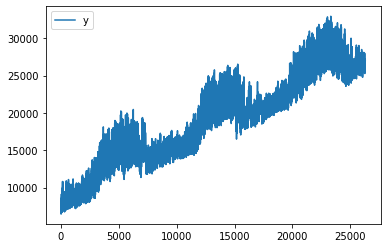

In [17]:
import numpy as np
df_global['y'] = np.where(df_global['ID']=='COAST',df_global['y'] + df_global.index / 2, df_global['y'] )
df_global[df_global['ID']=='COAST'].plot()


When a pd.DataFrame with an 'ID' column is the input for the `split_df` function, train and validation data are provided in a similar format. For global models, the input data is typically split according to a fraction of the time encompassing all time series (default when there is more than one 'ID' and when `local_split=False`). If the user wants to split each time series locally, the `local_split` parameter must be set to True. In this example, we will split our data into train and test (with a 33% test proportion - 2 years train and 1 year test).

In [18]:
df_train, df_test = m.split_df(df_global, valid_p = 0.33, local_split = True)

Global modeling lets us train our model based on a global or a local normalization. In the latter, each time series is normalized locally (each time series has its respective data params). In the former, we have unique data params which will be used in all the time series at hand. 

## Global Modeling - Local Normalization

The default fitting of global models is based on local data normalization. Each time series will have data normalization parameters associated with each 'ID' provided. We are going to define a model which predicts the next hour based on the last 24 hours.

**Remarks:** 
- Training a time series only with trend and seasonality components can result in . The following example is used just to show the new local modelling of multiple time series functionallity.
- Try different configurations of the trend: `trend_reg > 0`, `n_changepoints = 0`... Run `help(NeuralProphet)` or go to the official documentation for more information.

In [19]:
m = NeuralProphet(trend_global_local="local")

After creating an object of the `NeuralProphet`, a model can be created by calling the `fit` function.

In [20]:
metrics = m.fit(df_train, freq = 'H')

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Ensure you provide data identified with the keys associated with the appropriate train time series. Therefore, suitable normalization data parameters are used in post-fitting procedures (i.e., `predict`, `test`).

WARNING - (py.warnings._showwarnmsg) - /home/alfonso/Desktop/local_code/data_science/neural_prophet/neuralprophet/forecaster.py:2397: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - /home/alfonso/Desktop/local_code/data_science/neural_prophet/neuralprophet/forecaster.py:2397: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - /home/alfonso/Desktop/local_code/data_science/neural_prophet/neuralprophet/forecaster.py:2397: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - /home/alfonso/Desktop/local_code/data_science/neural_prophet/neuralprophe

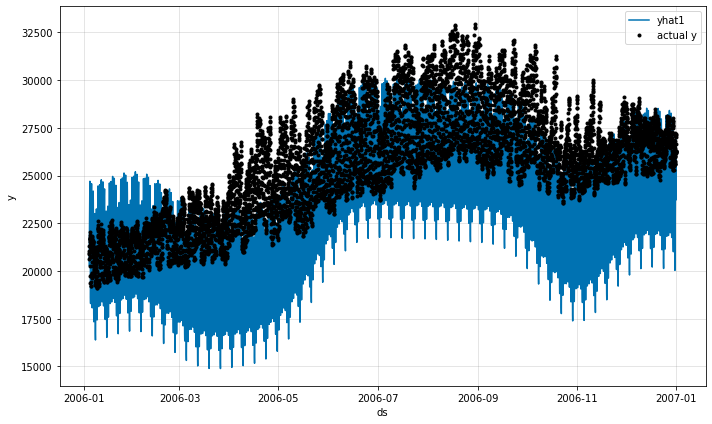

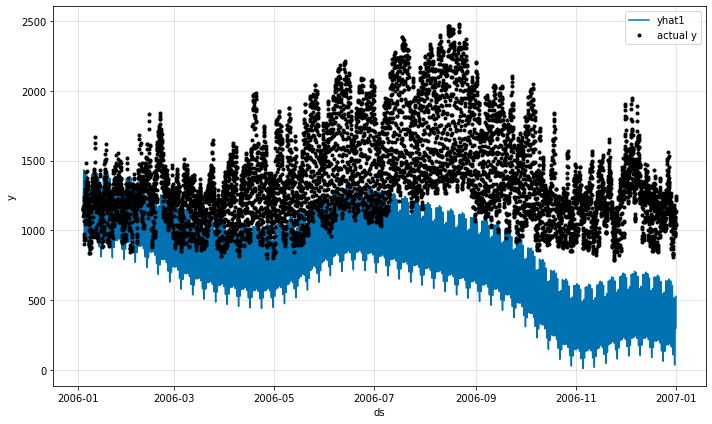

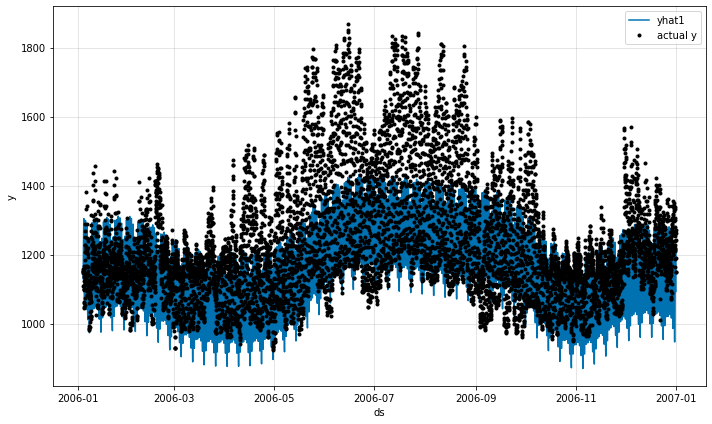

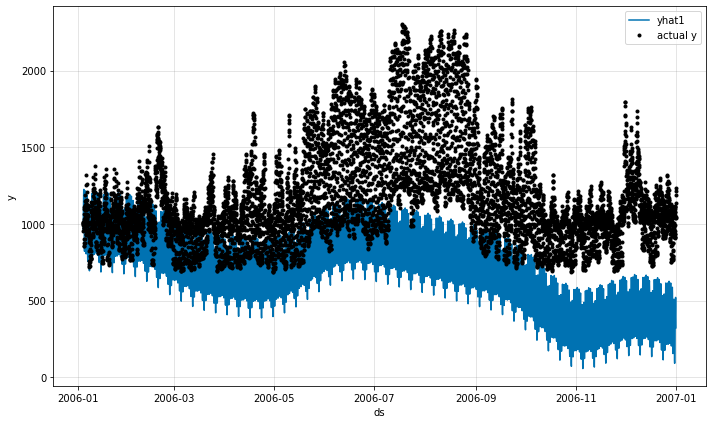

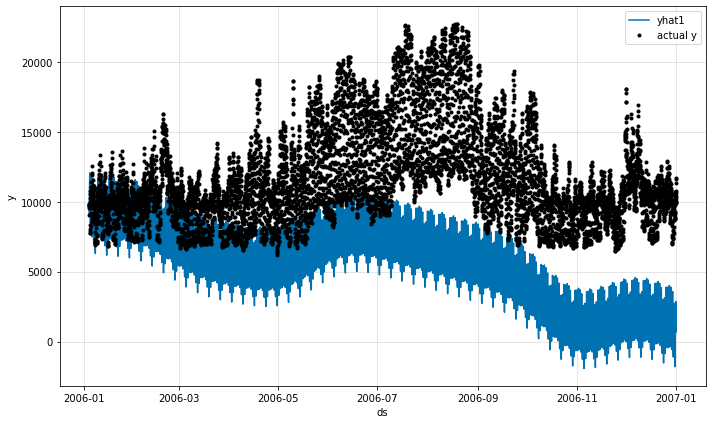

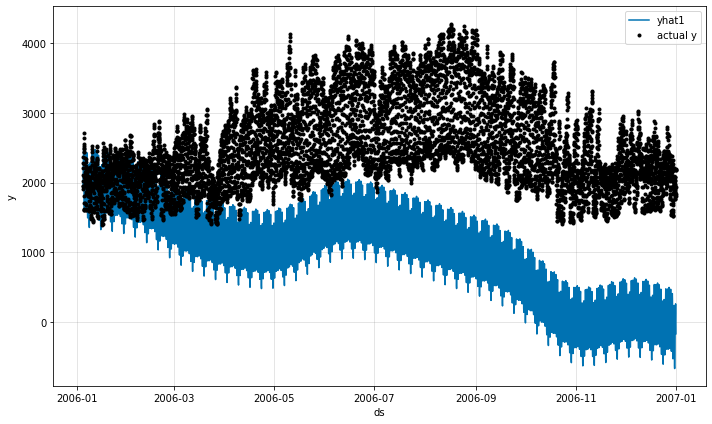

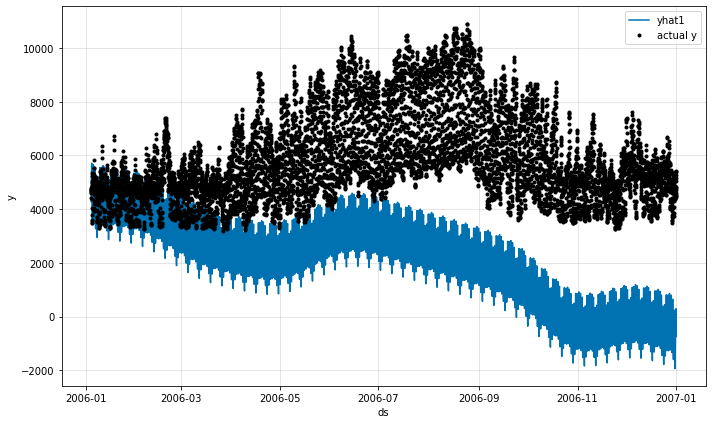

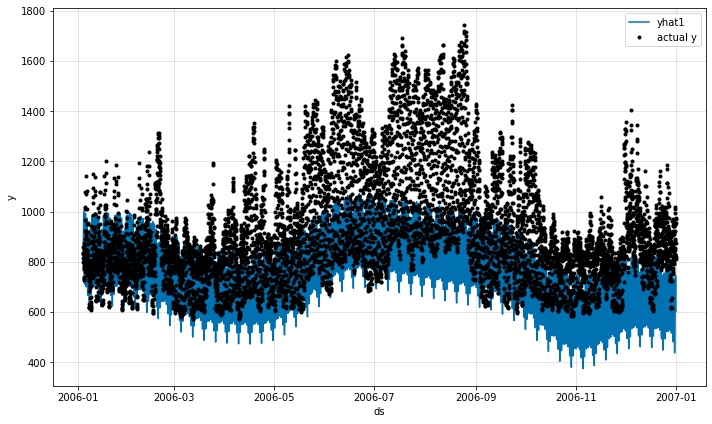

In [21]:
future = m.make_future_dataframe(df_test, n_historic_predictions = True)
forecast = m.predict(future)
for i in forecast['ID'].unique():
    fig = m.plot(forecast[forecast['ID'] ==  i])

In [23]:
test_metrics = m.test(df_test)
test_metrics

,SmoothL1Loss,MAE,RMSE
0,0.128151,0.402257,0.439846


Please note that in the case of local normalization, the test metrics are not re-scaled but displayed on a normalized scale.

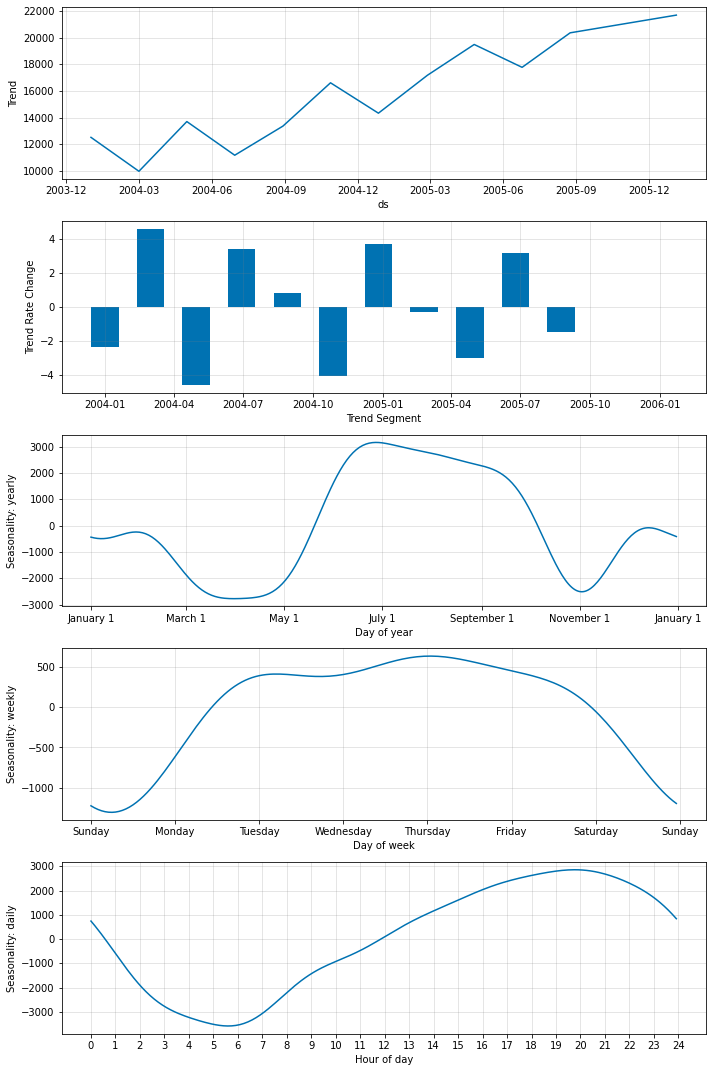

In [26]:
fig_param = m.plot_parameters(df_name='COAST')

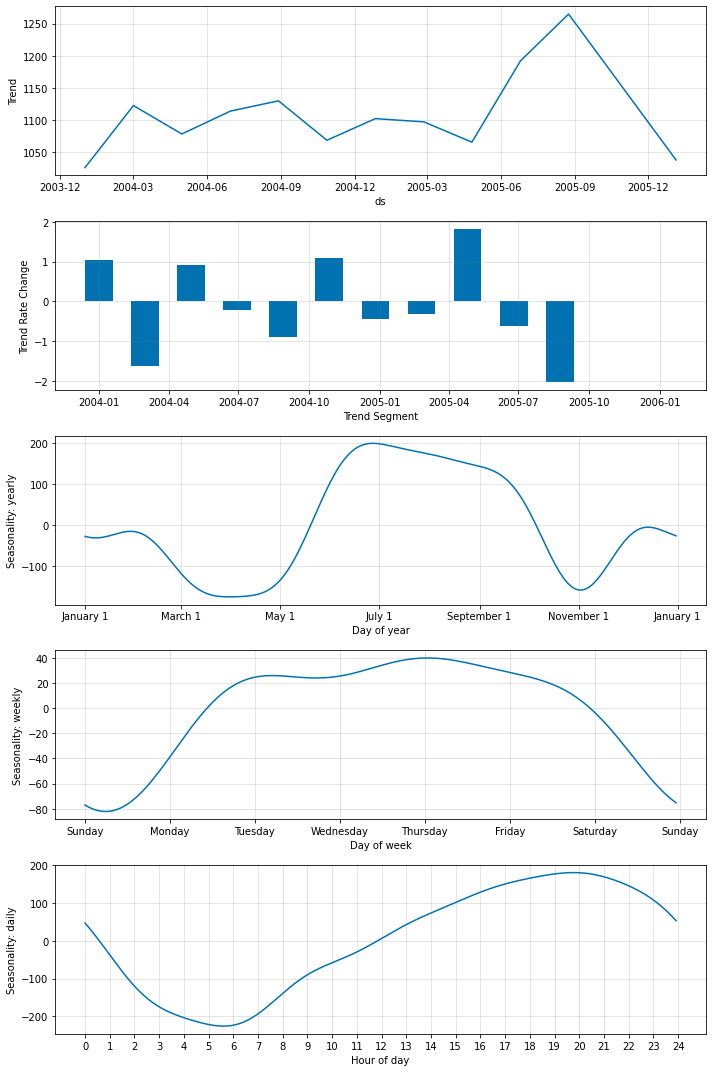

In [27]:
fig_param = m.plot_parameters(df_name='NORTH')